In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [8]:
dirPath = "data preprocessed"

means, stds = eval(open(dirPath + "\\means_and_stds_about_trainset.py").read())

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((33600, 18), (14400, 18), (12000, 17))

划分数据集特征和标签：

In [9]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]
trainSet.shape, validateSet.shape

((33600, 17), (14400, 17))

# 实现评测指标

In [128]:
def calcF1(predictLabel, realLabel, printRes=False):
    '''给定算法得到的分类结果和实际的分类结果，计算评测指标
    注意：标签为1则为正标签，标签不为1则为负标签'''
    def safeDivide(a, b):
        '''子函数：当分母为0时返回除式结果为 -1'''
        return a/b if b != 0 else 0
    
    TP = Counter(np.logical_and(predictLabel==1, realLabel==1))[True]
    FN = Counter(np.logical_and(predictLabel!=1, realLabel==1))[True]
    FP = Counter(np.logical_and(predictLabel==1, realLabel!=1))[True]
    if(printRes):
        print("TP FN FP", TP, FN, FP)
    F1 = safeDivide(2*TP, 2*TP+FN+FP)
    return F1

print('test 1: normal one')
calcF1(arr([1, 1, 0, 0]), arr([1, 0, 1, 0]), True)
print('\ntest 2: may have zero division error')
calcF1(arr([0, 0, 1, 0]), arr([1, 0, 1, 0]), True)

test 1: normal one
TP FN FP 1 1 1


0.5


test 2: may have zero division error
TP FN FP 1 1 0


0.6666666666666666

# 逻辑回归

In [29]:
class LogisticRegression:
    '''逻辑回归类实现'''
    
    def __addOne2Samples(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        return np.column_stack((ones, dataSet))
    
    def sigmoid(self, x):
        '''sigmoid函数实现'''
        return 1/(1+np.exp(-1*x))
    
    def fit(self, trainSet, label, eta=1e-3, lambda_=1, maxRunTimes=100):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        #设置默认的 w 全为1
        self.w = np.mat(np.ones(trainSet.shape[1]+1)).reshape(-1,1)
        #给训练集中每一个样本前加一个常数1，并转换为numpy矩阵
        trainSet = np.mat(self.__addOne2Samples(trainSet))
        #将标签转换为numpy矩阵，并将其设置为只有一列的数据的矩阵
        label = np.mat(label).reshape(-1,1)
        for i in range(maxRunTimes):
            eta_reduced = eta/(1+i)+1e-7
            #根据矩阵运算得到整个数据集每个维度梯度
            gradient = trainSet.transpose()*(self.sigmoid(trainSet*self.w) - label)
            #正则化
            gradient[1:,0] += lambda_*self.w[1:,0]
            #更新 w
            self.w -= eta_reduced*gradient
        
    def __apply(self, x):
        '''利用训练好的 w 对输入的向量x进行分类'''
        w = np.array(self.w)[:,0] #转换为numpy向量，方便后续计算
        return 1 if self.sigmoid(np.dot(w, x)) > 0.5 else 0
    
    def apply(self, otherSet):
        '''根据已训练出的 w 对其他数据集进行划分'''
        otherSet = self.__addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = self.__apply(sample)
        return outputLabel
    
    def getW(self):
        return np.array(self.w)[:,0]

# 调参

调参流程：eta->迭代次数->lambda

eta最优为0.1 基于这个数值，lambda最优为0.001

In [114]:
def getTestRange(testNumList):
    testScale = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1, 10]).reshape(-1,1)
    testNum = np.array(testNumList).reshape(1,-1)
    return (testNum*testScale).flatten() #广播运算

etaTestRange = getTestRange([0.5, 1])
lambdaTestRange = getTestRange([0.5, 1])

etaTestRange, lambdaTestRange

(array([  5.00000000e-05,   1.00000000e-04,   5.00000000e-04,
          1.00000000e-03,   5.00000000e-03,   1.00000000e-02,
          5.00000000e-02,   1.00000000e-01,   5.00000000e-01,
          1.00000000e+00,   5.00000000e+00,   1.00000000e+01]),
 array([  5.00000000e-05,   1.00000000e-04,   5.00000000e-04,
          1.00000000e-03,   5.00000000e-03,   1.00000000e-02,
          5.00000000e-02,   1.00000000e-01,   5.00000000e-01,
          1.00000000e+00,   5.00000000e+00,   1.00000000e+01]))

In [115]:
runTimeTestRange = np.arange(500, 3100, 100)
runTimeTestRange

array([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500,
       1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600,
       2700, 2800, 2900, 3000])

In [117]:
testRange = [(i, j, k) for i in runTimeTestRange for j in etaTestRange for k in lambdaTestRange]
len(testRange)

3744

In [118]:
def runLR(runTimes, eta_, lambda_):
    LR = LogisticRegression()
    LR.fit(trainSet, trainSetLabel, eta=eta_, lambda_ = lambda_, maxRunTimes=runTimes)
    ansLabel = LR.apply(validateSet)
    F1 = calcF1(ansLabel, validateSetLabel)
    return F1

F1s = []
for i in tnrange(len(testRange)):
    F1s.append(runLR(testRange[i][0], testRange[i][1], testRange[i][2]))
    
bestParam = testRange[np.argmax(F1s)]

In [125]:
bestParam, np.max(F1s)

((1200, 5.0, 0.10000000000000001), 0.73137277693827729)

In [120]:
InteractiveShell.ast_node_interactivity = "none"

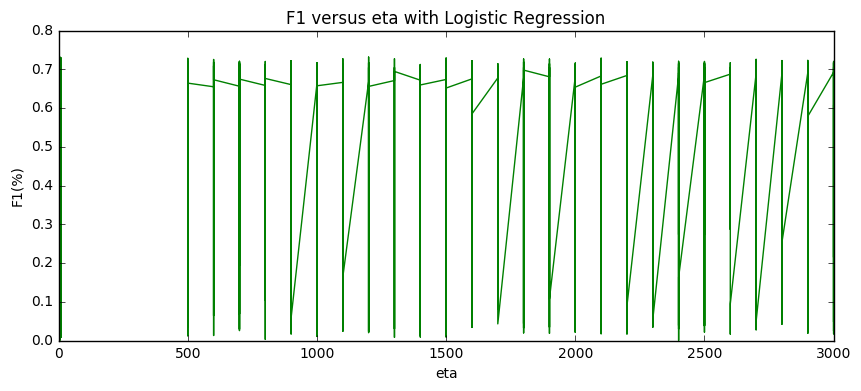

In [122]:
fig,ax = plt.subplots() 
fig.set_size_inches(10, 4)
plt.plot(testRange, F1s, 'g')
plt.xlabel('eta')
plt.ylabel('F1(%)')
plt.title("F1 versus eta with Logistic Regression")
plt.show()
plt.close()

In [123]:
InteractiveShell.ast_node_interactivity = "all"

# 应用算法到测试集

In [126]:
bestLR = LogisticRegression()
bestLR.fit(trainSet, trainSetLabel, eta=bestParam[1], lambda_ = bestParam[2], maxRunTimes=bestParam[0])
ansLabel = bestLR.apply(testSet)
np.savetxt('.\\rank\\47_v1.csv', ansLabel, fmt="%d", delimiter="\n")

In [127]:
one = Counter(ansLabel)[1.0]
zero = Counter(ansLabel)[0.0]
one/(one + zero)

0.70725